In [3]:
from collections import Counter
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler

In [137]:
#у это одномерный массив из 1 - человек отменил бронь, 0 - человек не отменил бронь
Y = data['booking status']
Y = np.array([1 if i =='Canceled' else 0 for i in Y])
Y.shape

(36285,)

In [138]:
#удаляем столбец того, что хотим предсказать, id, и сложноинтерпретируемый столбец дат
data = data.drop('booking status', axis=1)

data = data.drop('date of reservation', axis=1)

data = data.drop('Booking_ID', axis=1)

In [139]:
data

,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests
0,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0
1,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1
2,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0
3,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1
4,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36280,2,0,0,2,Meal Plan 2,0,Room_Type 1,346,Online,0,0,0,115.00,1
36281,2,0,1,3,Meal Plan 1,0,Room_Type 1,34,Online,0,0,0,107.55,1
36282,2,0,1,3,Meal Plan 1,0,Room_Type 4,83,Online,0,0,0,105.61,1
36283,3,0,0,4,Meal Plan 1,0,Room_Type 1,121,Offline,0,0,0,96.90,1


In [140]:
#кодируем в onehot категориальный признаки(загугли 1 картинку по onehot encoding и все станет понятно)
for col in ['type of meal', 'room type', 'market segment type']:
    data = pd.concat([data, pd.get_dummies(data[col])], axis=1)
    data = data.drop(col, axis=1)


In [141]:
#стандартизация данных чтоб они все были примерно одного диапазона значений
data = StandardScaler().fit(data).transform(data)


In [142]:
#разбиваем выборку на тренировочную и тестовую
x_train, x_test, y_train, y_test = train_test_split(data, Y, test_size=0.2)

### Начинаем обучение


In [143]:
# пойдем по порядку: логистическая регрессия 
model = LogisticRegression()#создание модели
model.fit(x_train, y_train) #обучение на тренировочном наборе
print(roc_auc_score(model.predict(x_test), y_test))# cчитаем метрику качества auc-roc 0.5- полное говно 1 - идеальная модель

0.7774750971702362


In [144]:
#переходим к деревьям: 
model = DecisionTreeClassifier(max_depth = 3)
model.fit(x_train, y_train) 
print(roc_auc_score(model.predict(x_test), y_test))

0.7525321692824929


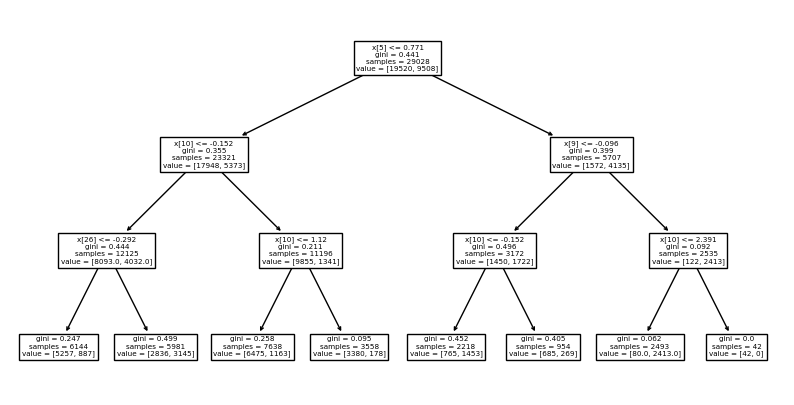

In [145]:
#нарисуем решающее дерево, суть в том, что оно в каждом узле задает вопрос, если ответ да, то идем на право, если нет, то налево, очень логичная модель
plt.figure(figsize=(10, 5))
a=plot_tree(model)


In [146]:
# теперь построим дерево другой глубины(подбор гиперпараметров(очень важная штука в мл), которые не обучаются сами, а определяют форму модели)
#перебираем макисмальнуб высоту дерева
for i in [2, 3, 5, 10, 15, 30]:
    model = DecisionTreeClassifier(max_depth = i)
    model.fit(x_train, y_train) 
    print("Глубина = ", i, roc_auc_score(model.predict(x_test), y_test))

Глубина =  2 0.7430367887812825
Глубина =  3 0.7525321692824929
Глубина =  5 0.8082684218095529
Глубина =  10 0.8532837548820654
Глубина =  15 0.8554419336511797
Глубина =  30 0.8388544485305304


In [147]:
#теперь бэггинг, модель основанная на композиции деревьев(строится н деревьев и их предсказание усредняется)
for i in [5, 10, 30, 50, 100, 300]:
    model = BaggingClassifier(n_estimators = i)
    model.fit(x_train, y_train) 
    print("кол-во деревьев= ", i, roc_auc_score(model.predict(x_test), y_test))

кол-во деревьев=  5 0.8599127172336176
кол-во деревьев=  10 0.8751832823659678
кол-во деревьев=  30 0.8750065151742872
кол-во деревьев=  50 0.8768433657009829
кол-во деревьев=  100 0.8788146698411538
кол-во деревьев=  300 0.8776133976119618


In [148]:
#случайный лес, почти то же самое, но в какомто смысле чуть лучше
for i in [5, 10, 30, 50, 100, 300]:
    model = RandomForestClassifier(n_estimators = i)
    model.fit(x_train, y_train) 
    print("кол-во деревьев= ", i, roc_auc_score(model.predict(x_test), y_test))

кол-во деревьев=  5 0.8645884317893573
кол-во деревьев=  10 0.871222788762735
кол-во деревьев=  30 0.8782351086992195
кол-во деревьев=  50 0.8784038748556786
кол-во деревьев=  100 0.879992100583488
кол-во деревьев=  300 0.8778704278526519


In [149]:
# и последний на сегодня классификатор: градиентный бустинг(тут тоже обучаются сразу куча деревьев,но по очереди, чтоб узнать и исправить ошибки друг друга)
for i in [0.01, 0.05, 0.07, 0.1, 0.5]:#перебираем гиперпараметр скорости и грубости обучения, 
    #чем он больше тем быстрее и грубее мы учимся, чем меньше, тем дольше но в какомто смысле точнее
    model = GradientBoostingClassifier(n_estimators = 300, learning_rate=i)#все модели берем из sklearn
    model.fit(x_train, y_train) 
    print("learning rate= ", i, roc_auc_score(model.predict(x_test), y_test))

learning rate=  0.01 0.8299981775104792
learning rate=  0.05 0.8476355953509463
learning rate=  0.07 0.8574280884014058
learning rate=  0.1 0.8583244855654988
learning rate=  0.5 0.8656650621146726


In [150]:
# тоже бустинг, но из библиотеки CatBoost(от яндекса)
for i in [2,3,4,5,10]:
    model = CatBoostClassifier(n_estimators = 300, max_depth=i)
    model.fit(x_train, y_train, verbose=0)# verbose =0 чтоб по пути не выводилась информация об обучении 
    print("глубина= ", i, roc_auc_score(model.predict(x_test), y_test))

глубина=  2 0.84039776949832
глубина=  3 0.8538813467814703
глубина=  4 0.8623356024637472
глубина=  5 0.8679382422996909
глубина=  10 0.8749951749291698


### ПОДЫТОЖИМ 
мы сегодня  потрогали пандас и немножко поработали с признаками
смогли обучить классификатор на 0.88 auc-roc, доля верных ответов такая же примерно(что не обязательно всегда выполняется, accuracy совершенно другая метрика, более информативная)
при этом рассмотрели все основные мл модели классификации

In [151]:
model = CatBoostClassifier(n_estimators = 300, max_depth=10)
model.fit(x_train, y_train, verbose=0)# verbose =0 чтоб по пути не выводилась информация об обучении 
print("доля верных ответов модели = ", accuracy_score(model.predict(x_test), y_test))#посчитаем для разнообразия другую метрику

доля верных ответов модели =  0.882182720132286


### Бонус 
регрессия 


In [8]:
data = pd.read_csv('booking.csv')
y = data['average price']
data = data.drop(['Booking_ID', 'date of reservation', 'average price', 'booking status'], axis=1)

FileNotFoundError: [Errno 2] No such file or directory: 'booking.csv'

In [153]:
data

,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,special requests
0,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,0
1,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,1
2,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,0
3,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,1
4,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36280,2,0,0,2,Meal Plan 2,0,Room_Type 1,346,Online,0,0,0,1
36281,2,0,1,3,Meal Plan 1,0,Room_Type 1,34,Online,0,0,0,1
36282,2,0,1,3,Meal Plan 1,0,Room_Type 4,83,Online,0,0,0,1
36283,3,0,0,4,Meal Plan 1,0,Room_Type 1,121,Offline,0,0,0,1


In [154]:
for col in ['type of meal', 'room type', 'market segment type']:
    data = pd.concat([data, pd.get_dummies(data[col])], axis=1)
    data = data.drop(col, axis=1)

In [ ]:
#загружаем таблицу
data = pd.read_csv('booking.csv')

In [155]:
data_ = StandardScaler().fit(data).transform(data)
x_train, x_test, y_train, y_test = train_test_split(data_, y, test_size=0.2)

In [156]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
mean_absolute_percentage_error(lin_reg.predict(x_test), y_test)

0.1909208019480055

<BarContainer object of 26 artists>

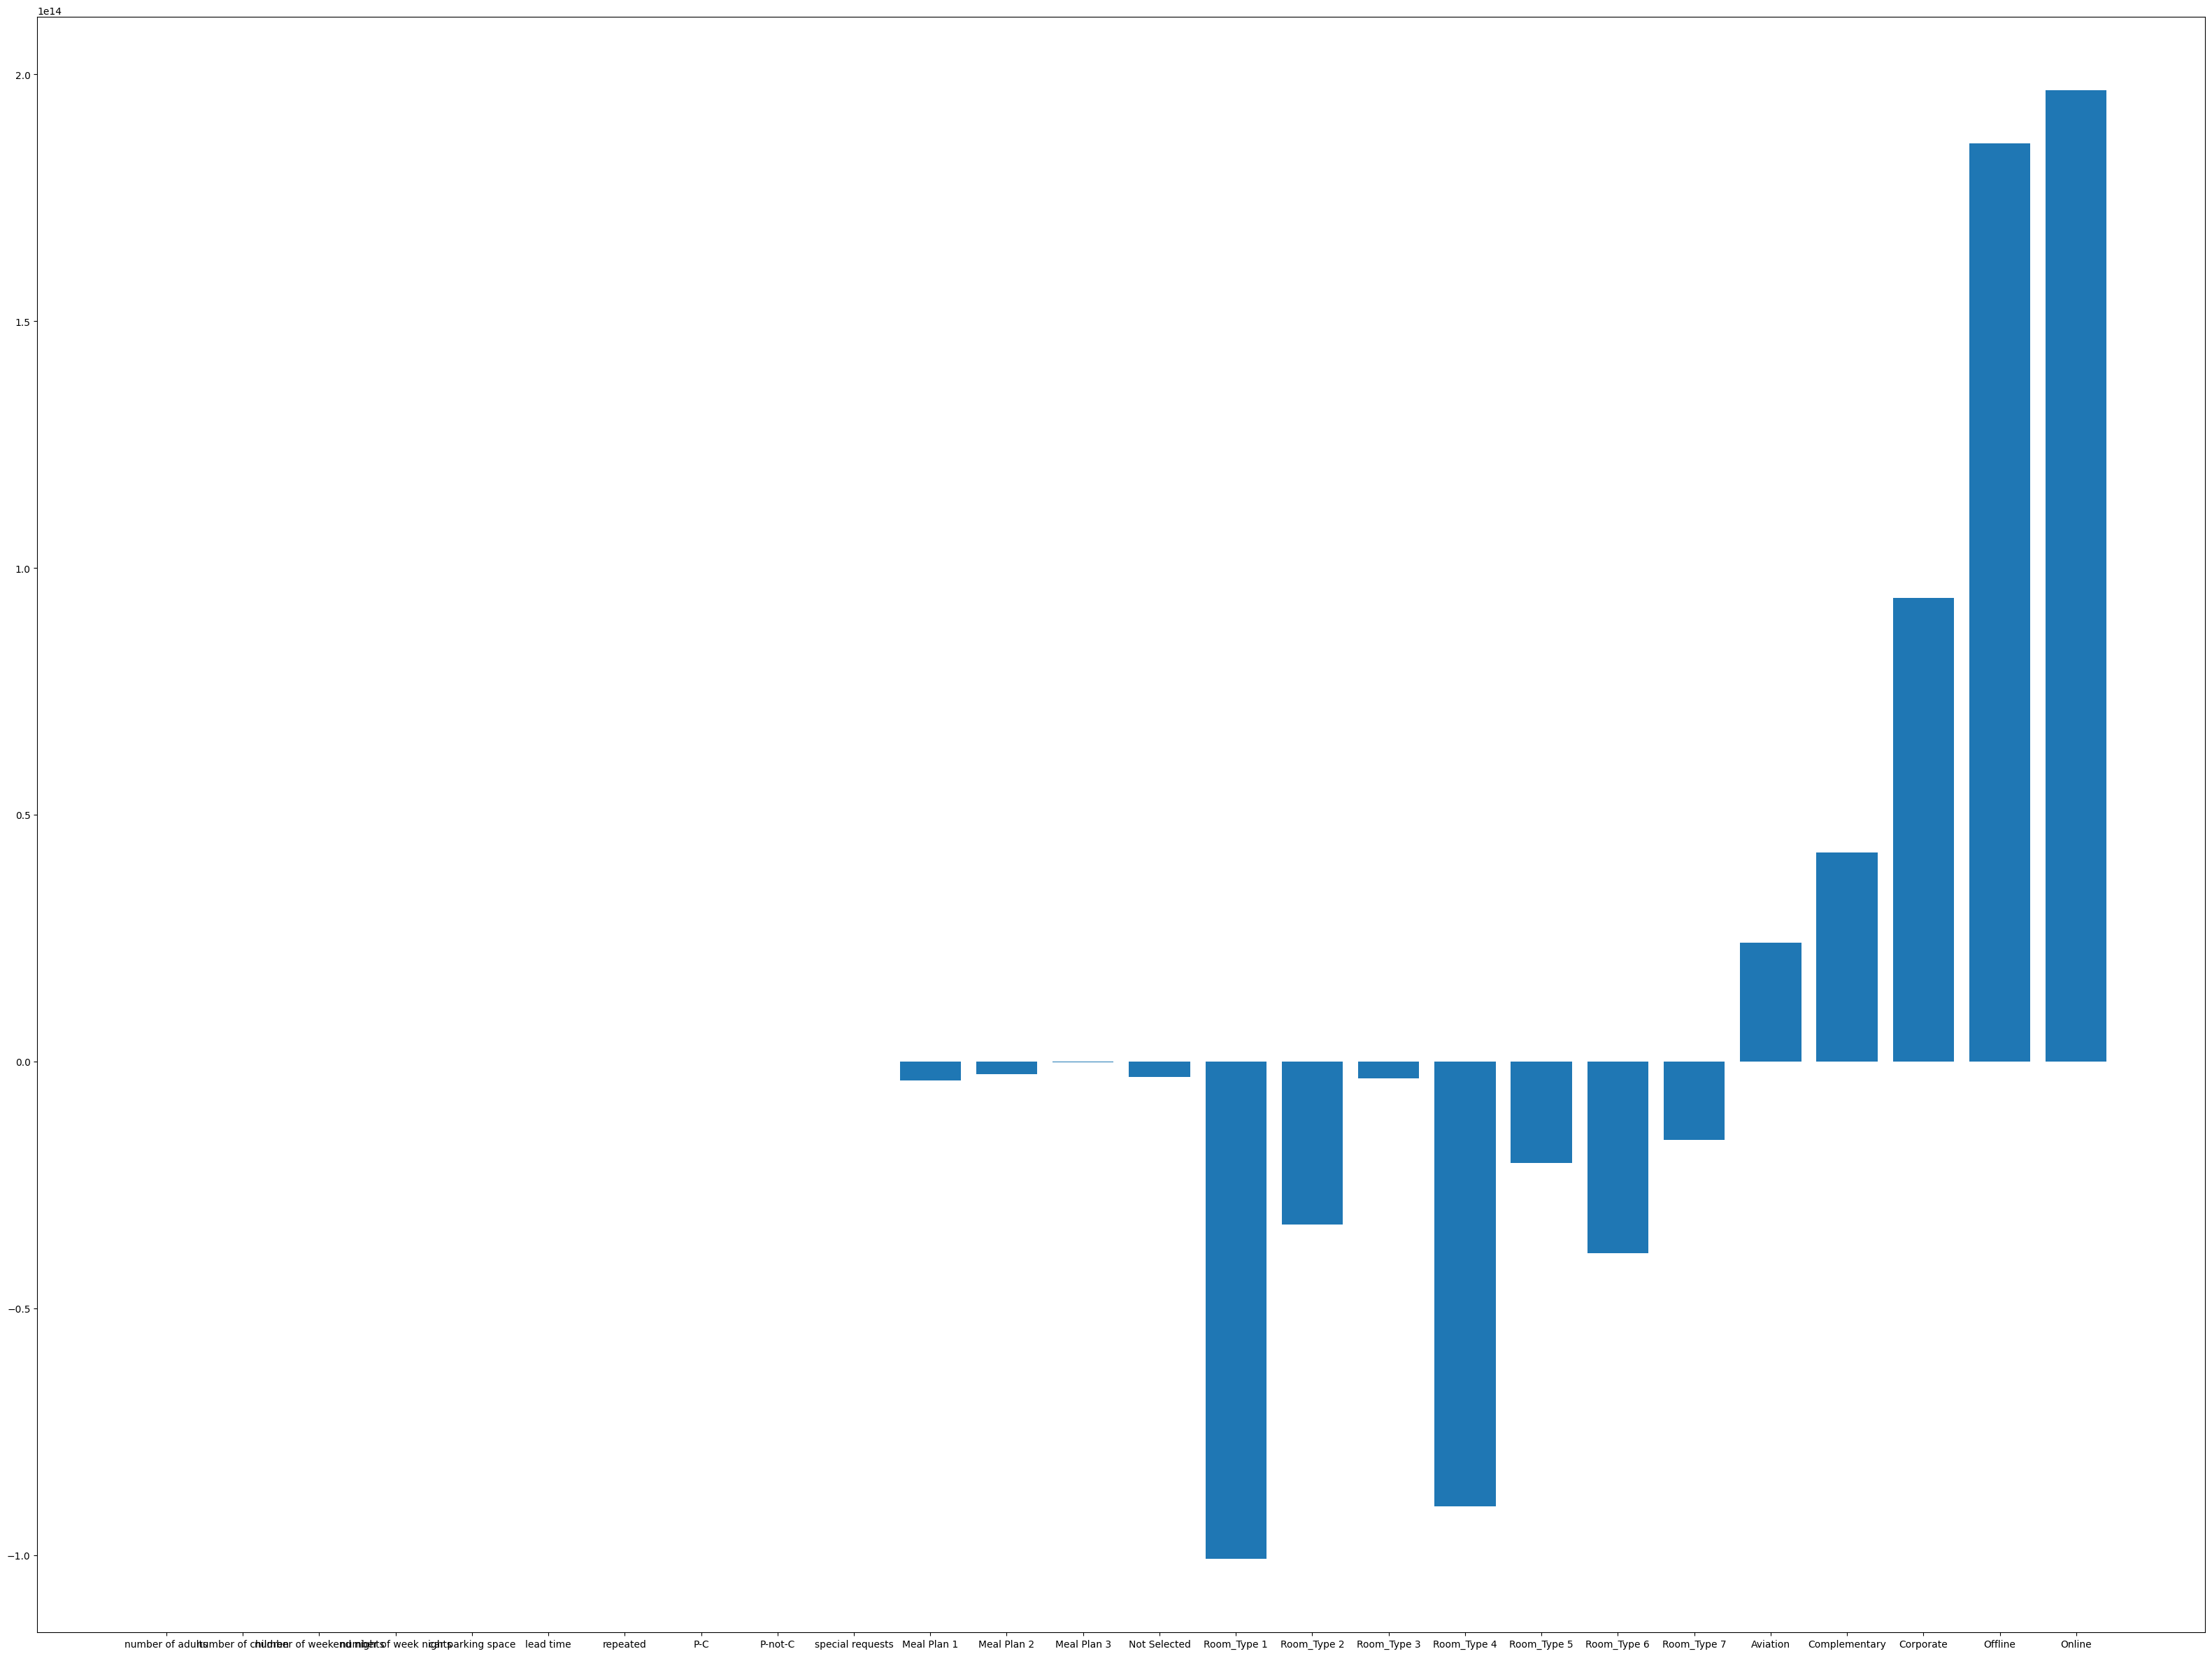

In [157]:
#выведем коэффициенты при признаках
plt.figure(figsize=(40, 30))
plt.bar(data.columns, lin_reg.coef_)

In [158]:
lin_reg.coef_

array([ 4.98487803e+00,  4.98390327e+00, -2.53126183e+00, -1.60075444e+00,
        1.32796978e+00, -2.31529950e+00, -1.72750600e+00, -3.62648476e-01,
       -3.16960030e-01,  1.29791258e+00, -3.84500782e+12, -2.61859771e+12,
       -1.06811314e+11, -3.17096814e+12, -1.00796024e+14, -3.30394854e+13,
       -3.35481533e+12, -9.00925222e+13, -2.05680312e+13, -3.88857691e+13,
       -1.59053204e+13,  2.40162892e+13,  4.23190584e+13,  9.39147953e+13,
        1.86034649e+14,  1.96750223e+14])

# как видим, некоторые коэффициенты пиздец большие, а некоторые совсем маленькие, чтоб все было примерно одного масштаба, используют Lasso

In [159]:
lin_reg = Lasso()
lin_reg.fit(x_train, y_train)
mean_absolute_percentage_error(lin_reg.predict(x_test), y_test)

0.19444893190698975

<BarContainer object of 26 artists>

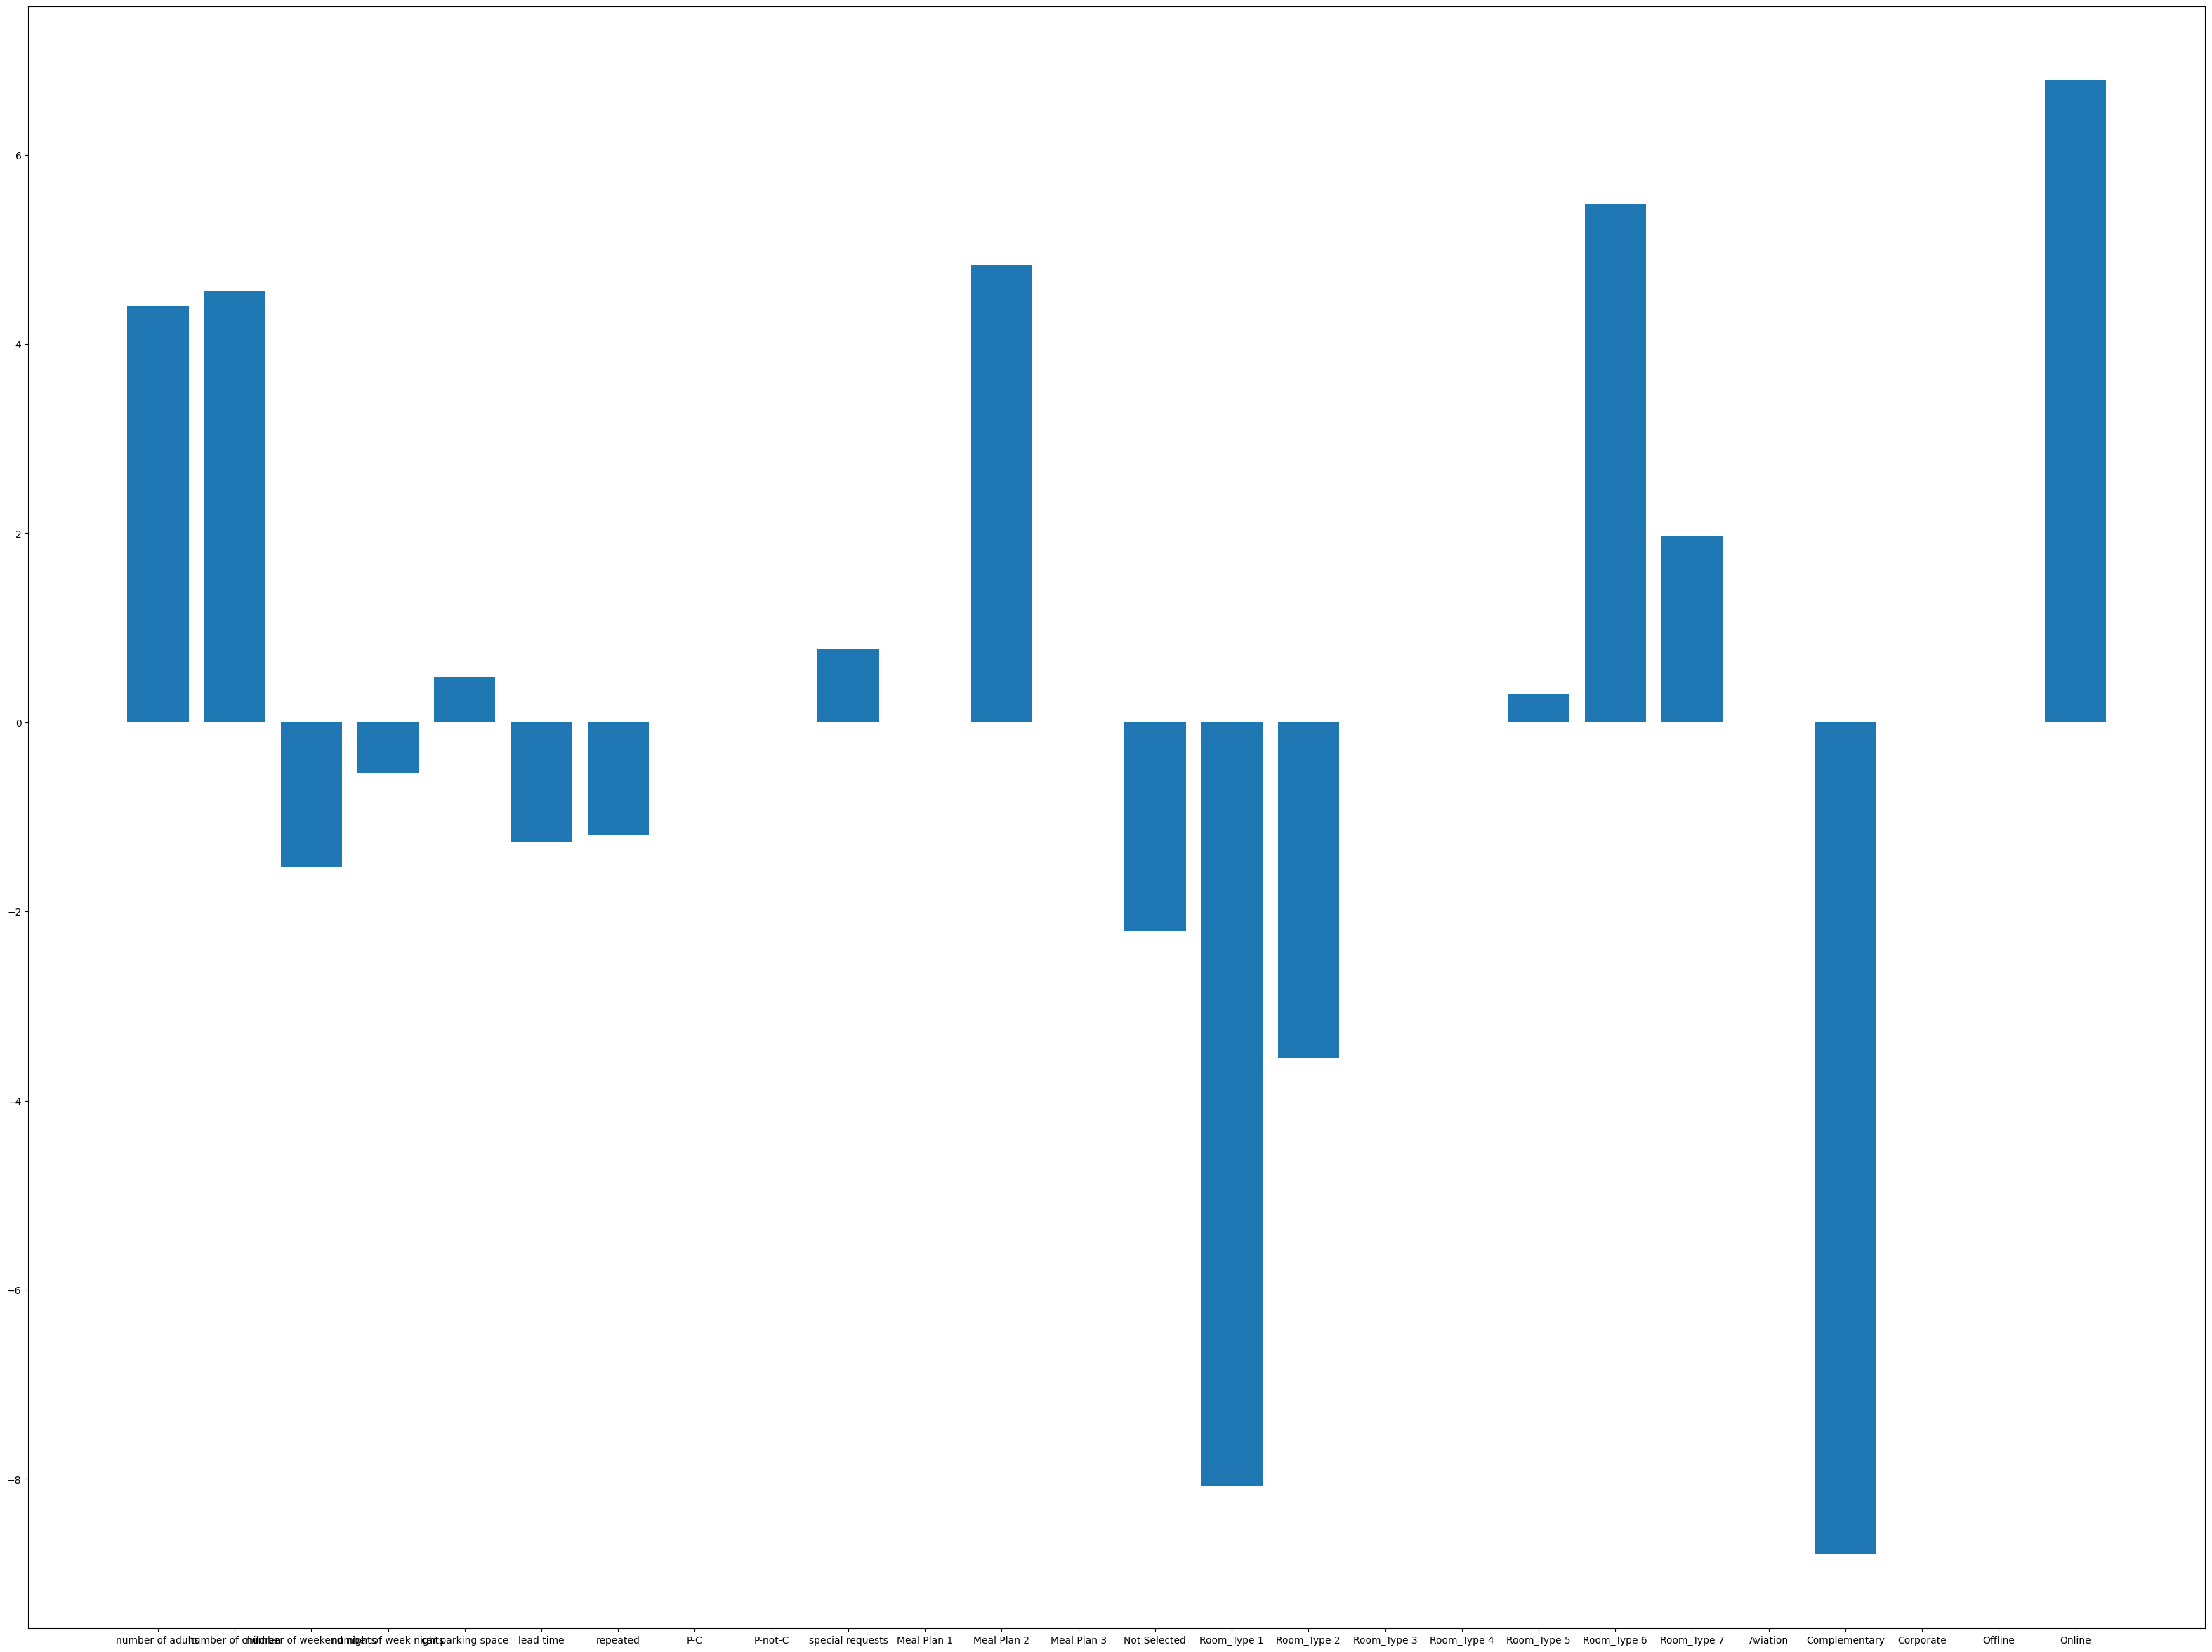

In [160]:
#выведем коэффициенты при признаках
plt.figure(figsize=(40, 30))
plt.bar(data.columns, lin_reg.coef_)

#### как видим, теперь веса одинаковые, как видим на цену больше всего влияют дорогие планы питания, типы номеров и наличие родственников в нем